## week02: Feature importances
_based on kaggle tutorials:_
* https://www.kaggle.com/neychev/exercise-shap-values
* https://www.kaggle.com/neychev/exercise-advanced-uses-of-shap-values-14c76e


We have again provided code to do the basic loading, review and model-building. Run the cell below to set everything up:

In [1]:
# If running on Colab, uncomment this cell
# ! pip install pdpbox
# ! pip install eli5
# ! pip install shap


In [2]:
import pandas as pd
data = pd.read_csv('data/medical.csv')
data.columns

Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'race_Caucasian',
       'race_AfricanAmerican', 'gender_Female', 'age_[70-80)', 'age_[60-70)',
       'age_[50-60)', 'age_[80-90)', 'age_[40-50)', 'payer_code_?',
       'payer_code_MC', 'payer_code_HM', 'payer_code_SP', 'payer_code_BC',
       'medical_specialty_?', 'medical_specialty_InternalMedicine',
       'medical_specialty_Emergency/Trauma',
       'medical_specialty_Family/GeneralPractice',
       'medical_specialty_Cardiology', 'diag_1_428', 'diag_1_414',
       'diag_1_786', 'diag_2_276', 'diag_2_428', 'diag_2_250', 'diag_2_427',
       'diag_3_250', 'diag_3_401', 'diag_3_276', 'diag_3_428',
       'max_glu_serum_None', 'A1Cresult_None', 'metformin_No',
       'repaglinide_No', 'nateglinide_No', 'chlorpropamide_No',
       'glimepiride_No', 'acetohexamide_No', 'glipizide_No', 'glyburide_No',
     

## The Scenario
A hospital has struggled with "readmissions," where they release a patient before the patient has recovered enough, and the patient returns with health complications. 

The hospital wants your help identifying patients at highest risk of being readmitted. Doctors (rather than your model) will make the final decision about when to release each patient; but they hope your model will highlight issues the doctors should consider when releasing a patient.

The hospital has given you relevant patient medical information.  Here is a list of columns in the data:


In [3]:
data.describe()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,readmitted
count,25000.000000,25000.00000,25000.000000,25000.000000,25000.000000,25000.000000,25000.00000,25000.000000,25000.000000
mean,4.395640,42.96012,1.341080,15.988440,0.365920,0.203280,0.64300,7.420160,0.456400
std,2.991165,19.76881,1.705398,8.107743,1.224419,0.982973,1.26286,1.940932,0.498105
min,1.000000,1.00000,0.000000,1.000000,0.000000,0.000000,0.00000,1.000000,0.000000
25%,2.000000,31.00000,0.000000,10.000000,0.000000,0.000000,0.00000,6.000000,0.000000
50%,4.000000,44.00000,1.000000,15.000000,0.000000,0.000000,0.00000,8.000000,0.000000
75%,6.000000,57.00000,2.000000,20.000000,0.000000,0.000000,1.00000,9.000000,1.000000
max,14.000000,126.00000,6.000000,81.000000,36.000000,64.000000,21.00000,16.000000,1.000000


Here are some quick hints at interpreting the field names:

- Your prediction target is `readmitted`
- Columns with the word `diag` indicate the diagnostic code of the illness or illnesses the patient was admitted with. For example, `diag_1_428` means the doctor said their first illness diagnosis is number "428".  What illness does 428 correspond to? You could look it up in a codebook, but without more medical background it wouldn't mean anything to you anyway.
- A column names like `glimepiride_No` mean the patient did not have the medicine `glimepiride`. If this feature had a value of False, then the patient did take the drug `glimepiride`
- Features whose names begin with `medical_specialty` describe the specialty of the doctor seeing the patient. The values in these fields are all `True` or `False`.


## Step 1:
You have built a simple model, but the doctors say they don't know how to evaluate a model, and they'd like you to show them some evidence the model is doing something in line with their medical intuition. Create any graphics or tables that will show them a quick overview of what the model is doing?

They are very busy. So they want you to condense your model overview into just 1 or 2 graphics, rather than a long string of graphics.

In [4]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

y = data.readmitted

base_features = [c for c in data.columns if c != "readmitted"]

X = data[base_features]


train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
my_model = RandomForestClassifier(n_estimators=30, random_state=1).fit(train_X, train_y)

In [6]:
# Use permutation importance as a succinct model summary
# A measure of model performance on validation data would be useful here too

import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(my_model, random_state=1).fit(val_X, val_y)
eli5.show_weights(perm, feature_names = val_X.columns.tolist())

Weight,Feature
0.0451 ± 0.0068,number_inpatient
0.0087 ± 0.0046,number_emergency
0.0062 ± 0.0053,number_outpatient
0.0033 ± 0.0016,payer_code_MC
0.0020 ± 0.0016,diag_3_401
0.0016 ± 0.0031,medical_specialty_Emergency/Trauma
0.0014 ± 0.0024,A1Cresult_None
0.0014 ± 0.0021,medical_specialty_Family/GeneralPractice
0.0013 ± 0.0010,diag_2_427
0.0013 ± 0.0011,diag_2_276


## Step 2

It appears `number_inpatient` is a really important feature. The doctors would like to know more about that. Create a graph for them that shows how `num_inpatient` affects the model's predictions.

In [7]:
# PDP for number_inpatient feature

from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

feature_name = 'number_inpatient'
# Create the data that we will plot
my_pdp = <YOUR CODE HERE>

# plot it
pdp.pdp_plot(my_pdp, feature_name)
plt.show()

<Figure size 1500x950 with 2 Axes>

## Step 3

The doctors think it's a good sign that increasing the number of inpatient procedures leads to increased predictions.  But they can't tell from this plot whether that change in the plot is big or small. They'd like you to create something similar for `time_in_hospital` to see how that compares.

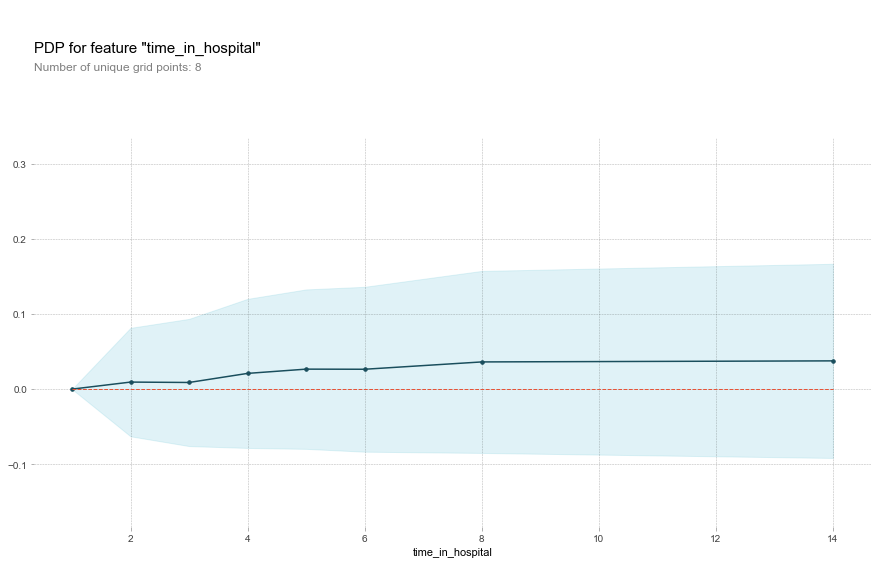

In [8]:
# The results are very different. Specifically time in hospital has a much smaller effect. Code below:

from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

feature_name = 'time_in_hospital'
# Create the data that we will plot
my_pdp = <YOUR CODE HERE>

# plot it
<YOUR CODE HERE>

## Step 4

Woah!  It seems like `time_in_hospital` doesn't matter at all.  The difference between the lowest value on the partial dependence plot and the highest value is about 5%.

If that is what your model concluded, the doctors will believe it. But it seems so low. Could  the data be wrong, or is your model doing something more complex than they expect?  

They'd like you to show them the raw readmission rate for each value of `time_in_hospital` to see how it compares to the partial dependence plot.

- Make that plot. 
- Are the results similar or different?

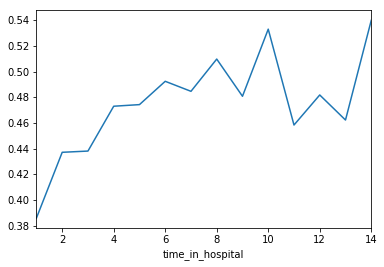

In [9]:
# A simple pandas groupby showing the average readmission rate for each time_in_hospital.

# Do concat to keep validation data separate, rather than using all original data
all_train = pd.concat([train_X, train_y], axis=1)

<YOUR CODE HERE>

## Step 5
Now the doctors are convinced you have the right data, and the model overview looked reasonable.  It's time to turn this into a finished product they can use. Specifically, the hospital wants you to create a function `patient_risk_factors` that does the following
- Takes a single row with patient data (of the same format you as your raw data)
- Creates a visualization showing what features of that patient increased their risk of readmission, what features decreased it, and how much those features mattered.

It's not important to show every feature with every miniscule impact on the readmission risk.  It's fine to focus on only the most important features for that patient.

In [10]:
# Use SHAP values to show the effect of each feature of a given patient

import shap  # package used to calculate Shap values

sample_data_for_prediction = val_X.iloc[0].astype(float)  # to test function

def patient_risk_factors(model, patient_data):
    # Create object that can calculate shap values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(patient_data)
    shap.initjs()
    return shap.force_plot(explainer.expected_value[1], shap_values[1], patient_data)


In [22]:
patient_risk_factors(my_model, val_X.iloc[5].astype(float))

## Questions time

In [12]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import shap


import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

data = pd.read_csv('data/medical.csv')
y = data.readmitted
base_features = ['number_inpatient', 'num_medications', 'number_diagnoses', 'num_lab_procedures', 
                 'num_procedures', 'time_in_hospital', 'number_outpatient', 'number_emergency', 
                 'gender_Female', 'payer_code_?', 'medical_specialty_?', 'diag_1_428', 'diag_1_414', 
                 'diabetesMed_Yes', 'A1Cresult_None']

# Some versions of shap package error when mixing bools and numerics
X = data[base_features].astype(float)

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

# For speed, we will calculate shap values on smaller subset of the validation data
small_val_X = val_X.iloc[:150]
my_model = RandomForestClassifier(n_estimators=30, random_state=1).fit(train_X, train_y)

The first few questions require examining the distribution of effects for each feature, rather than just an average effect for each feature.  Run the following cell for a summary plot of the shap_values for readmission. It will take about 20 seconds to run.

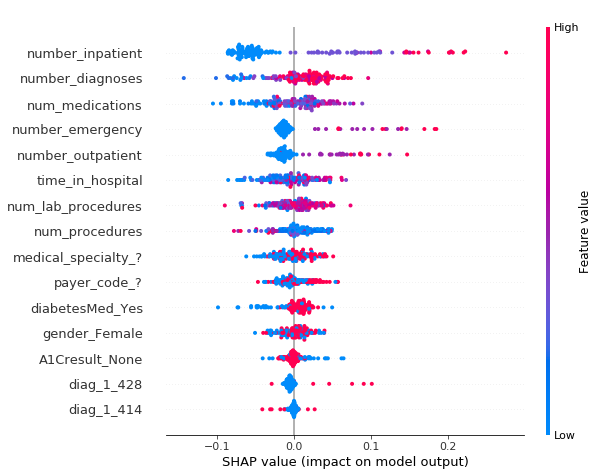

In [13]:
explainer = shap.TreeExplainer(my_model)
shap_values = explainer.shap_values(small_val_X)

shap.summary_plot(shap_values[1], small_val_X)

## Question 1

Which of the following features has a bigger range of effects on predictions (i.e. larger difference between most positive and most negative effect)
- `diag_1_428` or
- `payer_code_?`

## Question 2

Do you believe the range of effects sizes (distance between smallest effect and largest effect) is a good indication of which feature will have a higher permutation importance? Why or why not?  

If the **range of effect sizes** measures something different from **permutation importance**: which is a better answer for the question "Which of these two features does the model say is more important for us to understand when discussing readmission risks in the population?"

## Question 3

Both `diag_1_428` and `payer_code_?` are binary variables, taking values of 0 or 1.

From the graph, which do you think would typically have a bigger impact on predicted readmission risk:
- Changing `diag_1_428` from 0 to 1
- Changing `payer_code_?` from 0 to 1

To save you scrolling, we have included a cell below to plot the graph again (this one runs quickly).

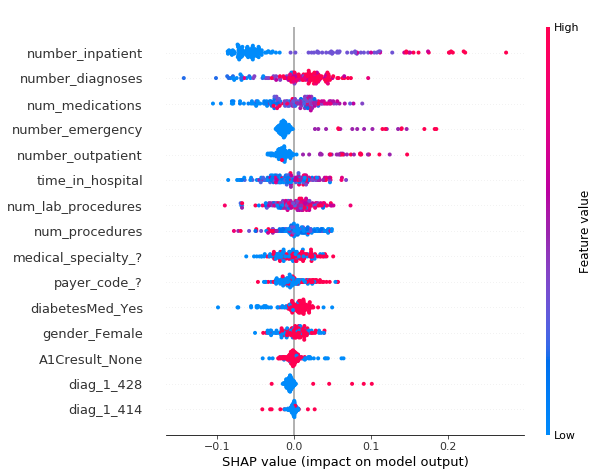

In [14]:
shap.summary_plot(shap_values[1], small_val_X)

## Question 4

Some features (like `number_inpatient`) have reasonably clear separation between the blue and pink dots. Other variables like `num_lab_procedures` have blue and pink dots jumbled together, even though the SHAP values (or impacts on prediction) aren't all 0.

What do you think you learn from the fact that `num_lab_procedures` has blue and pink dots jumbled together? Once you have your answer, uncomment the line below to verify your solution.

## Question 5

Consider the following SHAP contribution dependence plot. 

The x-axis shows `feature_of_interest` and the points are colored based on `other_feature`.

![Imgur](https://i.imgur.com/zFdHneM.png)

Is there an interaction between `feature_of_interest` and `other_feature`?  
If so, does `feature_of_interest` have a more positive impact on predictions when `other_feature` is high or when `other_feature` is low?

## Question 6

Review the summary plot for the readmission data by running the following cell:

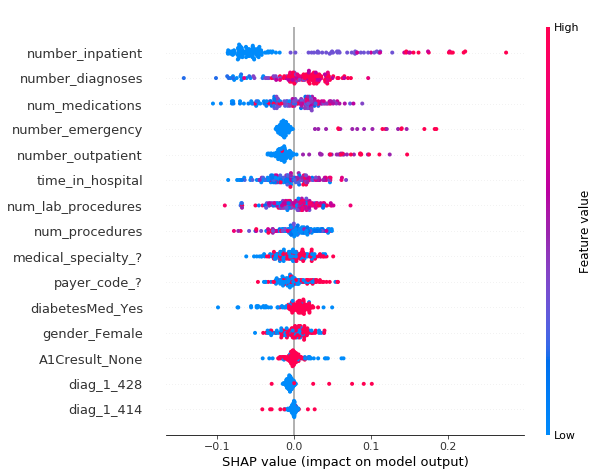

In [15]:
shap.summary_plot(shap_values[1], small_val_X)

1. Both **num_medications** and **num_lab_procedures** share that jumbling of pink and blue dots.

Aside from `num_medications` having effects of greater magnitude (both more positive and more negative), it's hard to see[](http://) a meaningful difference between how these two features affect readmission risk.  Create the SHAP dependence contribution plots for each variable, and describe what you think is different between how these two variables affect predictions.

As a reminder, here is the code you previously saw to create this type of plot.

    shap.dependence_plot(feature_of_interest, shap_values[1], val_X)
    
And recall that your validation data is called `small_val_X`.

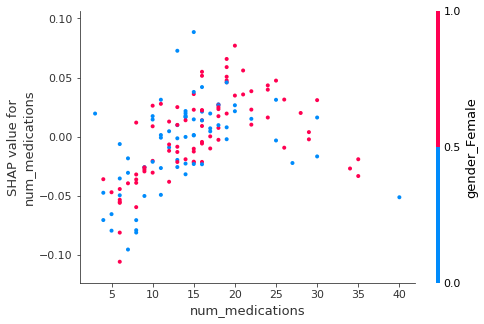

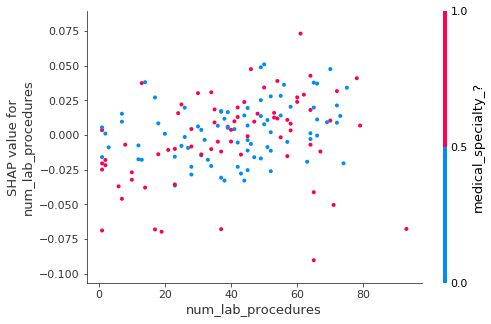

In [16]:
shap.dependence_plot('num_medications' ,shap_values[1], small_val_X)
shap.dependence_plot('num_lab_procedures' ,shap_values[1], small_val_X)

## Congrats

That's it!  Machine Learning models should not feel like black boxes any more, because you have the tools to inspect them and understand what they learn about the world. 

This is an excellent skill for debugging models, building trust, and learning insights to make better decisions. These techniques have revolutionized how I do data science, and I hope they do the same for you.

Kaggle has a lot of [free datasets](https://www.kaggle.com/datasets) to try out. If you learn something interesting about the world, share your work [in this forum](https://www.kaggle.com/learn-forum/66354). World (and original author of this tutorial) is excited to see what you do with your new skills.